In [53]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataclasses import dataclass
import logging
import sys
import warnings
from typing import Self
from scipy import constants 


context = xo.ContextCpu(omp_num_threads=4)
#context = xo.ContextCpu(omp_num_threads='auto')
# context = xo.ContextCpu()

line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [54]:
clight=constants.speed_of_light
circumference = line.get_length()

class Ion:
    def __init__(self, A, Z, q0, excited_lifetime, hw0):
        m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
        m_e = 0.511e6 # eV/c^2 -- electron mass
        m_p = 938.272088e6 # eV/c^2 -- proton mass

        self.A = A
        self.Z = Z 
        self.q0 = q0 #e
        self.excited_lifetime = excited_lifetime #s
        self.hw0 = hw0 #eV

        self.ne=Z-q0
        self.mass0=self.A*m_u + self.ne*m_e # eV/c^2

        N_pb = int(1.9*1e8) #ion-bunch intensity for lead
        self.N_a = int(N_pb*(self.Z/82)**-1.9) #ion-bunch intensity for arbitrary ion with charge Z
        self.Intensity = self.N_a

calcium=Ion(A=40, Z=20, q0=17, excited_lifetime=0.4279*1e-12, hw0=661.89)
xenon=Ion(A=129, Z=54, q0=39, excited_lifetime=3*1e-12, hw0=492.22)

ion=calcium

In [55]:
# Ion properties:
q0 = ion.q0
mass0 = ion.mass0

gamma = particle_ref.gamma0
beta= particle_ref.beta0
# beta = np.sqrt(1-1/(gamma*gamma)) # ion beta
p0c = gamma*mass0*beta #eV/c

bunch_intensity = ion.Intensity

particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

line.particle_ref=particle_ref


In [56]:
# # Source: https://www.sciencedirect.com/science/article/pii/S0146641020300399
# # Ion beam dimensions:
# sigma_x = 1.047e-3 # m
# sigma_y = 0.83e-3  # m
# sigma_z = 0.063 # m
# sigma_dp = 2e-4 # relative ion momentum spread

# sigma_px=4.36*1e-3 #calculated from the Twiss parameters
# sigma_py=4.36*1e-3 #calculated from the Twiss parameters

# num_particles = int(1e3)

# particles0 = xp.Particles(
#      mass0 = mass0, # eV/c^2
#      q0    = q0,
#      p0c   = p0c, # eV
#      x     = np.random.normal(scale=sigma_x, size=num_particles),
#      px    = np.random.normal(scale=sigma_px, size=num_particles),
#      y     = np.random.normal(scale=sigma_y, size=num_particles),
#      py    = np.random.normal(scale=sigma_py, size=num_particles),
#      zeta  = np.random.normal(scale=sigma_z, size=num_particles),
#      delta = np.random.normal(scale=sigma_dp, size=num_particles)
#         )

In [57]:
nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

emittance=nemitt*beta*gamma

num_particles=int(2e3)

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        particle_ref=particle_ref,
        line=line,
        
        )

particles0=particles.copy()
sigma_dp=2e-4  


*** Maximum RMS bunch length 0.2341160338197291m.
... distance to target bunch length: -6.3000e-02
... distance to target bunch length: 1.6465e-01
... distance to target bunch length: 7.8244e-02
... distance to target bunch length: -3.7042e-03
... distance to target bunch length: -7.4457e-05
... distance to target bunch length: -1.7737e-08
... distance to target bunch length: 3.0953e-07
--> Bunch length: 0.06299998226257152
--> Emittance: 0.1046315737310834


In [58]:
np.std(particles0.delta*1e4)

LinkedArrayCpu(0.95840981)

In [59]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
ion_excited_lifetime=ion.excited_lifetime
hw0 = ion.hw0 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy = 5e-3

GF_IP = xt.PulsedLaser(
                laser_x=0,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 1
int_time_s = 0.01
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e3)
# save_interval = num_turns/100
# # save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=num_particles)


line.discard_tracker()
IP_index=16675   
line.insert_element('monitor', element=monitor, index=IP_index)
line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
# SPS_line.append_element(monitor,'monitor')
# SPS_line.append_element(GF_IP,'GF_IP')


line.build_tracker(_context=context)
line.optimize_for_tracking()


Laser pulse duration sigma_t = 3.80 ps
Laser wavelength = 715.22 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [60]:
# particles=particles0.copy()

# line.track(particles, num_turns=num_turns,
#               turn_by_turn_monitor=False,with_progress=True)

# # extract relevant values
# x = monitor.x[:,:,0]
# px = monitor.px[:,:,0]
# y = monitor.y[:,:,0]
# py = monitor.py[:,:,0]
# delta = monitor.delta[:,:,0]
# zeta = monitor.zeta[:,:,0]
# state = monitor.state[:,:,0]
# time = monitor.at_turn[:, 0, 0] * T_per_turn

# np.savez('results/Pulsed_data.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta, state=state, time=time,s_per_turn=T_per_turn)

IBS


In [61]:
from xibs.analytical import NagaitsevIBS,BjorkenMtingwaIBS
from xibs.inputs import BeamParameters, OpticsParameters
from xibs.kicks import SimpleKickIBS

# Let's make sure we get logging output to demonstrate
logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="[%(asctime)s] [%(levelname)s] - %(module)s.%(funcName)s:%(lineno)d - %(message)s",
    datefmt="%H:%M:%S",
)

beamparams = BeamParameters.from_line(line, n_part=bunch_intensity)
opticsparams = OpticsParameters(twiss)
IBS = SimpleKickIBS(beamparams, opticsparams)
NIBS = NagaitsevIBS(beamparams, opticsparams)

def _bunch_length(parts: xp.Particles) -> float:
    return np.std(parts.zeta[parts.state > 0])


def _sigma_delta(parts: xp.Particles) -> float:
    return np.std(parts.delta[parts.state > 0])


def _geom_epsx(parts: xp.Particles, twiss: xt.TwissTable) -> float:
    """
    We index dx and betx at 0 which corresponds to the beginning / end of
    the line, since this is where / when we will be applying the kicks.
    """
    sigma_x = np.std(parts.x[parts.state > 0])
    sig_delta = _sigma_delta(parts)
    return (sigma_x**2 - (twiss["dx"][0] * sig_delta) ** 2) / twiss["betx"][0]


def _geom_epsy(parts: xp.Particles, twiss: xt.TwissTable) -> float:
    """
    We index dy and bety at 0 which corresponds to the beginning / end of
    the line, since this is where / when we will be applying the kicks.
    """
    sigma_y = np.std(parts.y[parts.state > 0])
    sig_delta = _sigma_delta(parts)
    return (sigma_y**2 - (twiss["dy"][0] * sig_delta) ** 2) / twiss["bety"][0]

[15:12:47] [INFO] - kicks.__init__:261 - No vertical dispersion in the lattice, using Nagaitsev formalism
[15:12:47] [INFO] - kicks.__init__:263 - This can be overridden manually, by explicitely setting the self.analytical_ibs attribute


In [62]:
ibs_step=50

ibs_kicks=[]

for i in tqdm(range(num_turns)):
    monitor.track(particles)
    line.track(particles)
    
    # if i % ibs_step:
        # IBS.compute_kick_coefficients(particles)
        # IBS.apply_ibs_kick(particles)  
        # ibs_kicks.append(IBS.compute_kick_coefficients(particles))

    # if i % ibs_step == 0:
    #     IBS.compute_kick_coefficients(particles)
    #     IBS.apply_ibs_kick(particles)

# extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
zeta = monitor.zeta[:,:,0]
state = monitor.state[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn


np.savez('results/Pulsed_data.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta, state=state, time=time,s_per_turn=T_per_turn)    

  0%|          | 0/43375 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


  0%|          | 3/43375 [00:03<12:27:05,  1.03s/it]

Done compiling ContextCpu kernels.


  3%|▎         | 1511/43375 [01:10<32:22, 21.55it/s]


KeyboardInterrupt: 

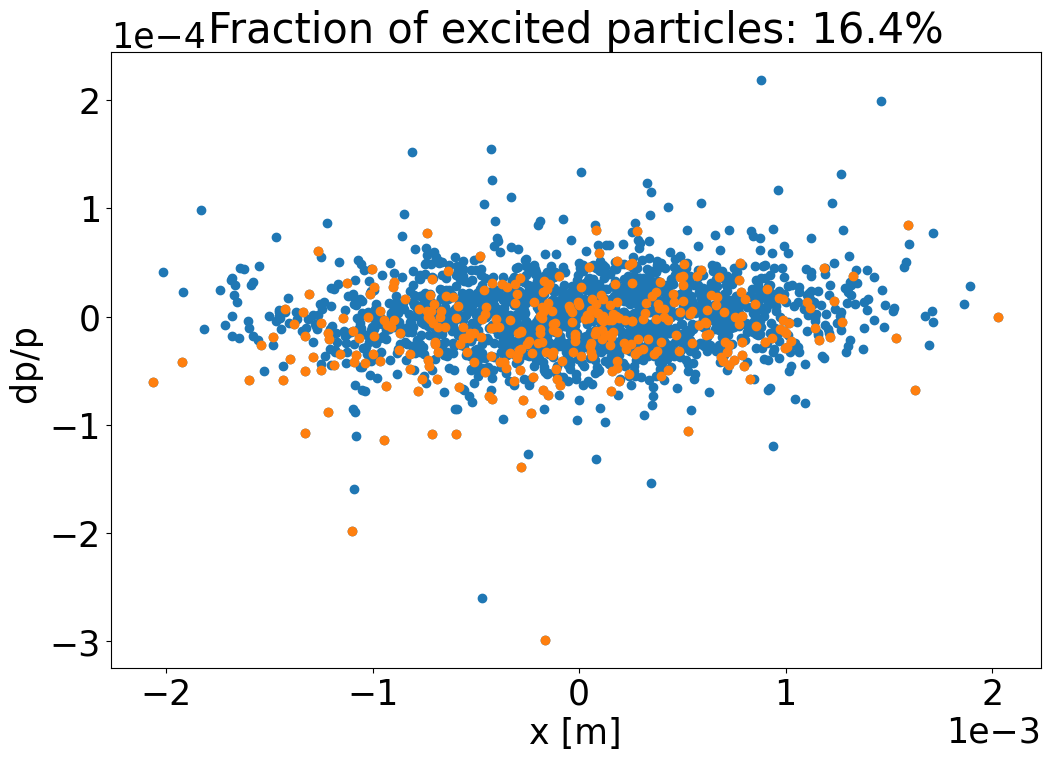

In [ ]:
excited=particles.state==2
fraction_excitation = sum(excited)/len(excited)


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(x[-1,:],delta[-1,:])
plt.scatter(x[-1,:][excited],delta[-1,:][excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()


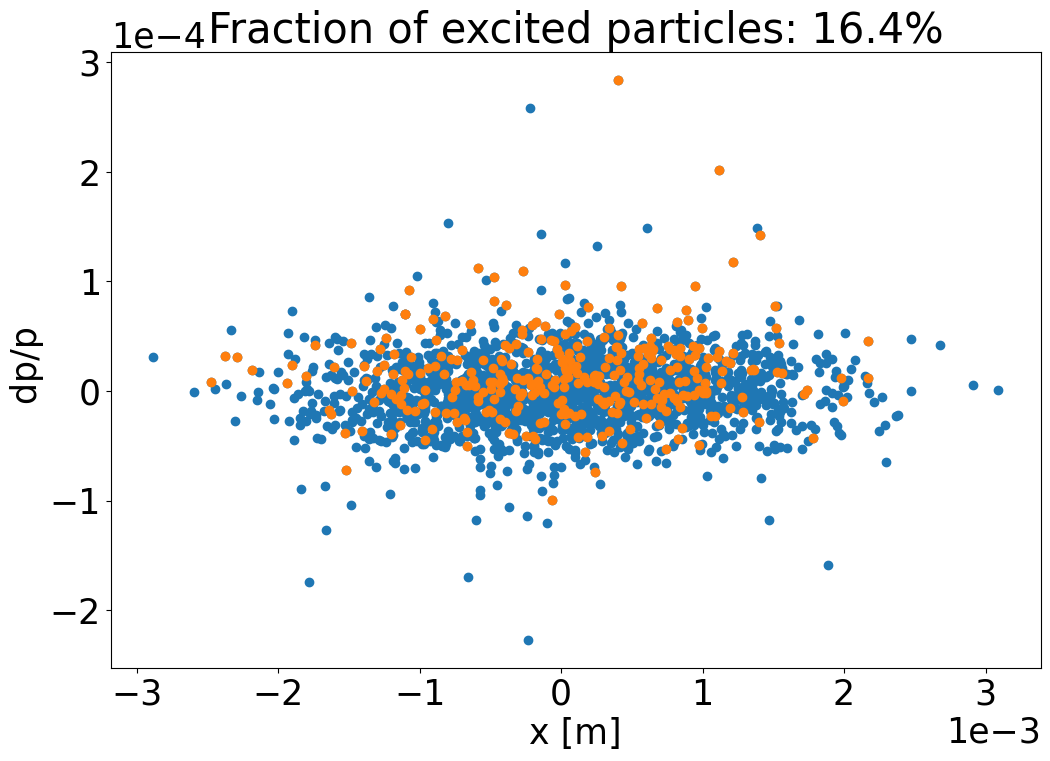

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

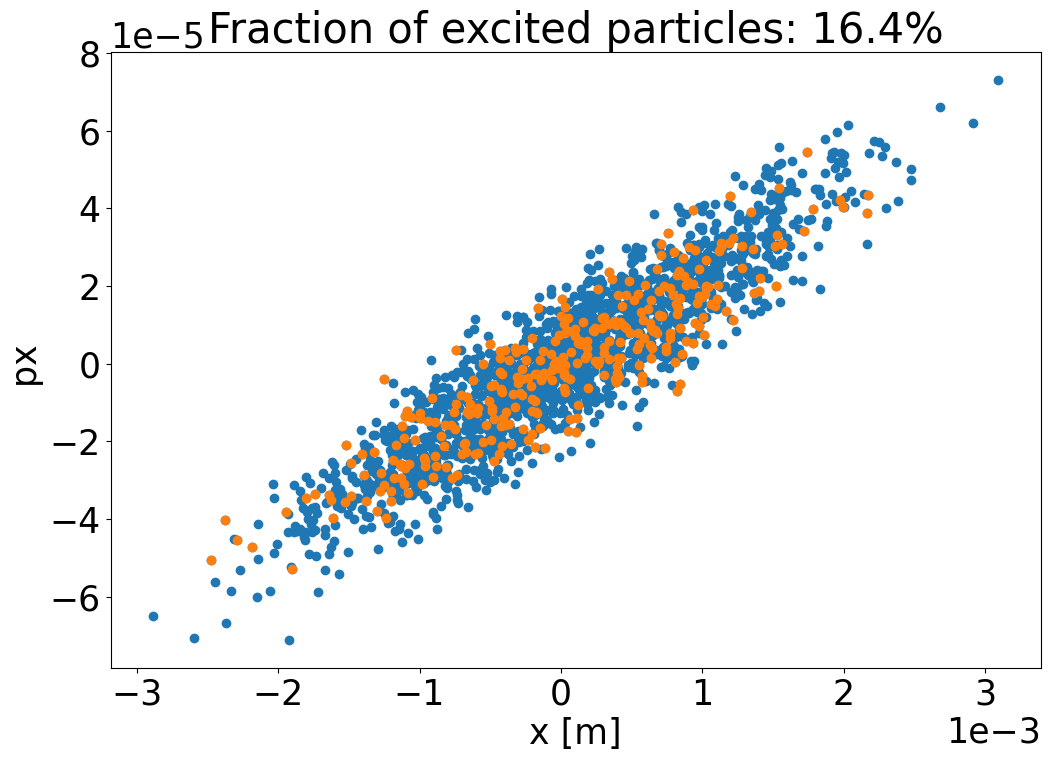

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()